<a href="https://colab.research.google.com/github/fosfrancesco/pitch-spelling/blob/main/rnncrf_pitch_spelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install --upgrade pytorch-crf

In [1]:
# from google.colab import files

import music21 as m21
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import pickle

from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn
import music21 as m21
from collections import Counter

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tqdm import tqdm, tqdm_notebook, notebook
import pickle

from sklearn.metrics import accuracy_score

import time

import kmeans1d
import jenkspy

from collections import defaultdict, Counter
# import optuna

# Pitch Spelling and ks Prediction

Dataset: different authors from ASAP collection
Challenges:
- extremely long sequences
- small dataset

In [2]:
pitches_dict = {
    0 : ["C","B#","D--"], # nn.Linear(input_size+context_size, 3)
    1 : ["C#","B##","D-"], # nn.Linear(input_size+context_size, 2)
    2 : ["D","C##","E--"], # nn.Linear(input_size+context_size, 3)
    3 : ["D#","E-","F--"],
    4 : ["E","D##","F-"],
    5 : ["F","E#","G--"],
    6 : ["F#","E##","G-"],
    7 : ["G","F##","A--"],
    8 : ["G#","A-"],
    9 : ["A","G##","B--"],
    10 : ["A#","B-","C--"],
    11 : ["B","A##","C-"]
}

accepted_pitches = [ii for i in pitches_dict.values() for ii in i]
print([e for e in enumerate(accepted_pitches)])

double_acc_pitches = [ii for i in pitches_dict.values() for ii in i if ii.endswith("##") or  ii.endswith("--") ]
print(double_acc_pitches)

def score2midi_numbers(score):
    return [p.midi%12 for n in score.flat.notes for p in n.pitches]

def score2pitches(score):
    return [p.name for n in score.flat.notes for p in n.pitches]

interval_dict = {
    0 : ["P1","d2","A7"], 
    1 : ["m2","A1"], 
    2 : ["M2","d3","AA1"], 
    3 : ["m3","A2"],
    4 : ["M3","d4","AA2"],
    5 : ["P4","A3"],
    6 : ["d5","A4"],
    7 : ["P5","d6","AA4"],
    8 : ["m6","A5"],
    9 : ["M6","d7","AA5"],
    10 : ["m7","A6"],
    11 : ["M7","d1","AA6"]
}

accepted_intervals = [ii for i in interval_dict.values() for ii in i]
print([e for e in enumerate(accepted_intervals)])

def transp_score(score):
    """ For each input return len(accepted_intervals) transposed scores"""
    return [score.transpose(interval) for interval in accepted_intervals]

def smart_transp_score(score):
    """ For each chromatic interval chose the interval that lead to the smallest number of accidentals"""
    scores = []
    for chromatic_int in interval_dict.keys():
        temp_scores = []
        temp_acc_number = []
        for diat_interval in interval_dict[chromatic_int]:
            new_score = score.transpose(diat_interval)
            temp_scores.append(new_score)
            temp_acc_number.append(sum([pitch.count("#") + pitch.count("-") for pitch in score2pitches(new_score)]))
            # print("choice:", [note.name for note in temp_scores[-1].flat.notes][0:10],"acc:",temp_acc_number[-1] )
        #keep only the one with the lowest number of accidentals
        min_index = np.argmin(temp_acc_number)
        # print("preferred the number", min_index)
        scores.append(temp_scores[min_index])
    return scores

def acc_simple_enough(score,accepted_ratio = 0.2 ):
    pitches = score2pitches(score)
    double_acc = sum(el in double_acc_pitches for el in pitches)
    if double_acc/len(pitches) < accepted_ratio:
        return True
    else:
        return False

diatonic_pitches = ["C","D", "E", "F", "G", "A", "B"]

accepted_ks = list(range(-7,8))

print(accepted_ks)

# #test acc_simple_enough()
# score = m21.converter.parse(paths[356])
# scores = smart_transp_score(score)
# #delete the pieces with non accepted pitches (e.g. triple sharps)
# scores = [s for s in scores if all(pitch in accepted_pitches for pitch in score2pitches(s))]
# for s in scores:
#     print(s.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0], "simple enough:", acc_simple_enough(s))
#     print([n.name for n in s.flat.notes])

[(0, 'C'), (1, 'B#'), (2, 'D--'), (3, 'C#'), (4, 'B##'), (5, 'D-'), (6, 'D'), (7, 'C##'), (8, 'E--'), (9, 'D#'), (10, 'E-'), (11, 'F--'), (12, 'E'), (13, 'D##'), (14, 'F-'), (15, 'F'), (16, 'E#'), (17, 'G--'), (18, 'F#'), (19, 'E##'), (20, 'G-'), (21, 'G'), (22, 'F##'), (23, 'A--'), (24, 'G#'), (25, 'A-'), (26, 'A'), (27, 'G##'), (28, 'B--'), (29, 'A#'), (30, 'B-'), (31, 'C--'), (32, 'B'), (33, 'A##'), (34, 'C-')]
['D--', 'B##', 'C##', 'E--', 'F--', 'D##', 'G--', 'E##', 'F##', 'A--', 'G##', 'B--', 'C--', 'A##']
[(0, 'P1'), (1, 'd2'), (2, 'A7'), (3, 'm2'), (4, 'A1'), (5, 'M2'), (6, 'd3'), (7, 'AA1'), (8, 'm3'), (9, 'A2'), (10, 'M3'), (11, 'd4'), (12, 'AA2'), (13, 'P4'), (14, 'A3'), (15, 'd5'), (16, 'A4'), (17, 'P5'), (18, 'd6'), (19, 'AA4'), (20, 'm6'), (21, 'A5'), (22, 'M6'), (23, 'd7'), (24, 'AA5'), (25, 'm7'), (26, 'A6'), (27, 'M7'), (28, 'd1'), (29, 'AA6')]
[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


## Import ASAP dataset

In [3]:
# !git clone https://github.com/fosfrancesco/pitch-spelling.git

basepath = "./" #to change if running locally or on colab

In [4]:
# load the asap datasets with ks
with open(Path('../asapks.pkl'), 'rb') as fid:
     full_dict_dataset = pickle.load( fid)


In [5]:
paths = list(set([e["original_path"] for e in full_dict_dataset ]))

# print(paths)
print(len(paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_dict_dataset ]))


222 different pieces
Average number of notes:  2410.253424657534


## Chose the convenient data augmentation
Two possibilities:
- for each chromatic interval, take only the diatonic transposition that produce the smallest number of accidentals (or the original if present)
- take only a certain interval of time signatures

The second is probably better for a smaller and simple dataset, but gives the problem of chosing between for example F# and G# that are both present in this bigger dataset. So we go for the first criterion.

In [6]:
# choose only one enharmonic version for each chromatic interval for each piece
dict_dataset = []
for path in paths:
    for c in range(12):
        pieces_to_consider = [opus for opus in full_dict_dataset 
                              if (opus["original_path"] == path and opus["transposed_of"] in interval_dict[c])  ]
        # if the original is in pieces_to_consider, go with the original
        originals = [opus for opus in pieces_to_consider if opus["transposed_of"] == "P1"]
        if len(originals) == 1:
            dict_dataset.append(originals[0])
        else: #we go with the accidental minization criteria
            n_accidentals = [sum([pitch.count("#") + pitch.count("-") for pitch in opus["pitches"]]) 
                            for opus in pieces_to_consider]
            if len(pieces_to_consider)>0:
                dict_dataset.append(pieces_to_consider[np.argmin(n_accidentals)])
            else:
                print("No options for", path, ". Chromatic: ",c )
                
#also remove unaccepted ks
print("Before removing according to ks:", len(dict_dataset))
dict_dataset = [e for e in dict_dataset if all([k in accepted_ks for k in e["key_signatures"]])]
print("After removing according to ks:", len(dict_dataset))
                                                    

# #test if it worked
# for i,e in enumerate(dict_dataset):
#     print(e["original_path"], e["transposed_of"], e["key_signatures"])
#     print(e["pitches"][:10])
#     print(e["midi_number"][:10])
#     if i == 100:
#         break

No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  4
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  6
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  9
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  11
No options for Liszt/Transcendental_Etudes/11/xml_score.musicxml . Chromatic:  1
No options for Liszt/Transcendental_Etudes/11/xml_score.musicxml . Chromatic:  6
No options for Chopin/Etudes_op_10/4/xml_score.musicxml . Chromatic:  4
No options for Chopin/Etudes_op_10/4/xml_score.musicxml . Chromatic:  9
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  1
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  4
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  6
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  9
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  11
No options for Liszt/Transc

In [7]:
print(len(dict_dataset))

c = Counter()
for p in paths:
    c[p.split("/")[0]] +=1

print(c)

2406
Counter({'Bach': 59, 'Beethoven': 57, 'Chopin': 34, 'Liszt': 16, 'Schubert': 13, 'Haydn': 11, 'Schumann': 10, 'Mozart': 6, 'Ravel': 4, 'Rachmaninoff': 4, 'Scriabin': 2, 'Debussy': 2, 'Brahms': 1, 'Glinka': 1, 'Balakirev': 1, 'Prokofiev': 1})


In [8]:
# remove pieces from asap that are in Musedata
print(len(paths), "initial pieces")
paths = [p for p in paths if p!= "Bach/Prelude/bwv_865/xml_score.musicxml"]

#remove mozart Fantasie because of incoherent key signature
paths = [p for p in paths if p!= 'Mozart/Fantasie_475/xml_score.musicxml']

print(len(paths), "pieces after removing overlapping with musedata and Mozart Fantasie")

222 initial pieces
220 pieces after removing overlapping with musedata and Mozart Fantasie


In [9]:
# Temporary remove composer with only one piece, because they create problems with sklearn stratify
one_piece_composers = ['Balakirev','Prokofiev','Brahms','Glinka', 'Debussy', 'Ravel', 'Scriabin','Liszt']
paths = [p for p in paths if p.split("/")[0] not in one_piece_composers]

# Divide train and validation set
path_train, path_validation = sklearn.model_selection.train_test_split(paths, test_size=0.15,stratify=[p.split("/")[0] for p in paths ])
print("Train and validation lenghts: ",len(path_train),len(path_validation))



Train and validation lenghts:  163 29


['Mozart', 'Schumann', 'Haydn', 'Schubert', 'Rachmaninoff', 'Chopin', 'Bach', 'Beethoven']


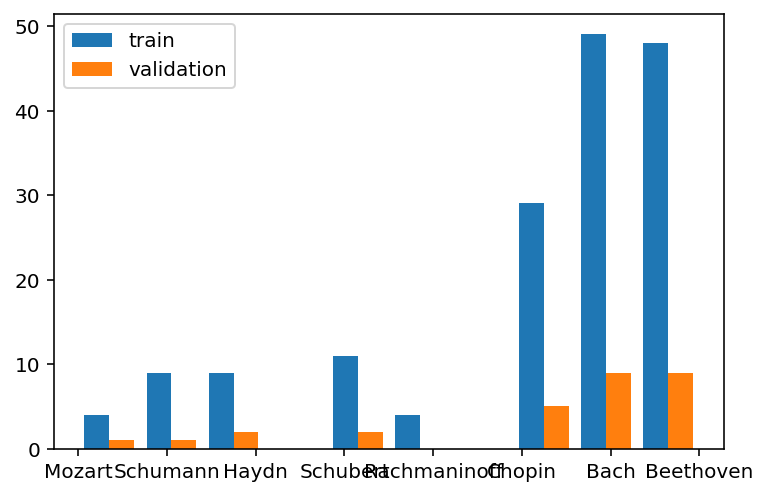

In [10]:
#need to find a better way to visualize this
composers = list(set([p.split("/")[0] for p in paths ]))
print(composers)

train_composer = [composers.index(p.split("/")[0]) for p in path_train]
val_composer = [composers.index(p.split("/")[0]) for p in path_validation]

_ = plt.hist([train_composer, val_composer], label=['train', 'validation'])
_ = plt.legend(loc='upper left')
_ = plt.xticks(list(range(len(composers))), composers)

## Transform the input into a convenient format for the Model

In [11]:
# Helper functions to feed the correct input into the NN 

N_DURATION_CLASSES = 4
PAD = "<PAD>"

pitch_to_ix = {p: accepted_pitches.index(p) for p in accepted_pitches}
ks_to_ix = {k: accepted_ks.index(k) for k in accepted_ks}
#add PADDING TAD
pitch_to_ix[PAD] = len(accepted_pitches)
ks_to_ix[PAD] = len(accepted_ks)

midi_to_ix = {m: m for m in range(12)}
#add PADDING TAD
midi_to_ix[PAD] = 12

# print(midi_to_ix[1])
# print(len(midi_to_ix))



# class Pitch2Diatonic():
#     def __call__(self, in_seq):
#         return [p for p in in_seq]

class Pitch2Int():
    def __call__(self, in_seq):
        idxs = [pitch_to_ix[w] for w in in_seq]
        return idxs
    
class Ks2Int():
    def __call__(self, in_seq):
        idxs = [ks_to_ix[w] for w in in_seq]
        return idxs

class Int2Pitch():
    def __call__(self, in_seq):
        return [accepted_pitches[i] for i in in_seq]

class OneHotEncoder():
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample,weights = None):
        onehot = np.zeros([len(sample), self.alphabet_len])
        tot_chars = len(sample)
        onehot[np.arange(tot_chars), sample] = 1
        return onehot
    
# class DurationOneHotEncoder():
#     def __init__(self, pitch_alphabet_len, n_dur_class = 4):
#         self.pitch_alphabet_len = pitch_alphabet_len
#         self.dur_alphabet_len = n_dur_class
        
#     def __call__(self, sample, durs):
#         sample = torch.tensor(sample,dtype=torch.long)
#         onehot_pitch = torch.nn.functional.one_hot(sample,self.pitch_alphabet_len)
#         #compute breaks in duration list
#         if len(set(durs)) > N_DURATION_CLASSES: 
#             breaks = jenkspy.jenks_breaks(list(set(durs)), nb_class=N_DURATION_CLASSES)
#             #quantize according to the breaks selected
#             quantized_durations = np.digitize(durs,breaks[1:-1])
#         elif len(set(durs)) > 2 : # in this case jenks breaks would throw an exception 
#             temp_n_classes = len(set(durs)) -1
#             breaks = jenkspy.jenks_breaks(list(set(durs)), nb_class=temp_n_classes)
#             # add lower classes to have the same number for all dataset
#             for __ in range(N_DURATION_CLASSES-temp_n_classes):
#                 breaks = [breaks[0]/2] + breaks
#             #quantize according to the breaks selected
#             quantized_durations = np.digitize(durs,breaks[1:-1])
#         else: # just use custom default
#             #quantize according to the breaks selected
#             quantized_durations = [1 for d in durs]        
#         quantized_durations = torch.tensor(quantized_durations,dtype=torch.long)
#         onehot_duration = torch.nn.functional.one_hot(quantized_durations,self.dur_alphabet_len)
#         return torch.cat([onehot_pitch,onehot_duration],1)

class DurationOneHotEncoder():
    def __init__(self, pitch_alphabet_len, n_dur_class = 4):
        self.pitch_alphabet_len = pitch_alphabet_len
        self.dur_alphabet_len = n_dur_class
        
    def __call__(self, sample, durs):
        sample = torch.tensor(sample,dtype=torch.long)
        onehot_pitch = torch.nn.functional.one_hot(sample,self.pitch_alphabet_len)
        #compute breaks in duration list
        clusters, centroids = kmeans1d.cluster(durs, N_DURATION_CLASSES)   
        quantized_durations = torch.tensor(clusters,dtype=torch.long)
        onehot_duration = torch.nn.functional.one_hot(quantized_durations,self.dur_alphabet_len)
        return torch.cat([onehot_pitch,onehot_duration],1)
    
        
class ToTensorFloat():
    def __call__(self, sample, durs = None):
        if type(sample) is torch.Tensor:
            return sample.float()
        else:
            return torch.tensor(sample,dtype=torch.float)

class ToTensorLong():
    def __call__(self, sample):
        if type(sample) is torch.Tensor:
            return sample.long()
        else:
            return torch.tensor(sample,dtype=torch.long)
    
class MultInputCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample, durs):
        for t in self.transforms:
            sample = t(sample, durs)
        return sample


### Define the preprocessing pipeline
transform_diat = transforms.Compose([Pitch2Int(),ToTensorLong()])
transform_chrom = MultInputCompose([DurationOneHotEncoder(len(midi_to_ix),N_DURATION_CLASSES),ToTensorFloat()])
transform_key = transforms.Compose([Ks2Int(),ToTensorLong()])


print(set([ks_to_ix[ks] for piece in dict_dataset for ks in piece["key_signatures"]]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [12]:
# Create the dataset

class PSDataset(Dataset):
    def __init__(self, dict_dataset, paths, transf_c, transf_d, transf_k, augment_dataset, sort =False, truncate = None):
        if sort:
            dict_dataset = sorted(dict_dataset, key = lambda e: (len(e['midi_number'])),reverse=True)
        if not augment_dataset: #remove the transposed pieces
            dict_dataset = [e for e in dict_dataset if e["transposed_of"]=="P1"]
        #consider only pieces in paths
        dict_dataset = [e for e in dict_dataset if e["original_path"] in paths]
        
        #extract the useful data from dataset        
        self.chromatic_sequences = [e["midi_number"] for e in dict_dataset]
        self.diatonic_sequences = [e["pitches"] for e in dict_dataset]
        self.durations = [e["duration"] for e in dict_dataset]
        self.ks = [e["key_signatures"] for e in dict_dataset]

        #the transformations to apply to data
        self.transf_c = transf_c
        self.transf_d = transf_d
        self.transf_ks = transf_k
        self.truncate = truncate

    def __len__(self):
        return len(self.chromatic_sequences)

    def __getitem__(self, idx):
        chromatic_seq = self.chromatic_sequences[idx]
        diatonic_seq = self.diatonic_sequences[idx]
        duration_seq = self.durations[idx]    
        ks_seq = self.ks[idx] 

        #transform
        chromatic_seq = self.transf_c(chromatic_seq,duration_seq)
        diatonic_seq = self.transf_d(diatonic_seq)
        ks_seq = self.transf_ks(ks_seq)

        if not self.truncate is None:
            if len(diatonic_seq) > self.truncate:
                chromatic_seq = chromatic_seq[0:self.truncate]
                diatonic_seq = diatonic_seq[0:self.truncate]
                ks_seq = ks_seq[0:self.truncate]

        #sanity check
        assert len(chromatic_seq) == len(diatonic_seq) == len(ks_seq)
        seq_len = len(diatonic_seq)
        
        return chromatic_seq, diatonic_seq, ks_seq, seq_len

train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True, sort = True)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

print(len(train_dataset),len(validation_dataset))


# test if it works
for chrom,diat,ks,seq_len in validation_dataset:
    print(chrom.shape)
#     print(torch.argmax(chrom[0:30],1))
#     # print([diatonic_pitches[p.item()] for p in diat[0:30]])
#     print([accepted_pitches[p.item()] for p in diat[0:30]])
    print([p.item() for p in ks[0:30]])
    print(seq_len)

1834 28
torch.Size([611, 17])
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
611
torch.Size([2776, 17])
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
2776
torch.Size([1423, 17])
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
1423
torch.Size([804, 17])
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
804
torch.Size([847, 17])
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
847
torch.Size([3878, 17])
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
3878
torch.Size([1827, 17])
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
1827
torch.Size([1722, 17])
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,

In [13]:
def pad_collate(batch):
    (xx, yy,zz, l) = zip(*batch)
    
    xx_pad = pad_sequence(xx, padding_value=midi_to_ix[PAD])
    yy_pad = pad_sequence(yy, padding_value=pitch_to_ix[PAD])
    zz_pad = pad_sequence(zz, padding_value=ks_to_ix[PAD])

    #sort the sequences by length
    seq_lengths, perm_idx = torch.Tensor(l).sort(0, descending=True)
    xx_pad = xx_pad[:,perm_idx,:]
    yy_pad = yy_pad[:,perm_idx]
    zz_pad = zz_pad[:,perm_idx]

    return xx_pad, yy_pad,zz_pad, seq_lengths

data_loader = DataLoader(dataset=validation_dataset, batch_size=4, shuffle=True, collate_fn=pad_collate)

#test if it work
for batch in data_loader:
    print(batch[0].shape,batch[1].shape,batch[2].shape)
    print(batch[0])
    break

torch.Size([2566, 4, 17]) torch.Size([2566, 4]) torch.Size([2566, 4])
tensor([[[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  1.,  0.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.]],

        [[ 1.,  0.,  0.,  ...,  0.,  1.,  0.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 

## Model Definition

In [14]:
class RNNTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, pitch_to_ix,ks_to_ix,n_layers =1):
        super(RNNTagger,self).__init__()    
        
        self.n_out_pitch = len(pitch_to_ix)
        self.n_out_ks = len(ks_to_ix)
        self.hidden_dim = hidden_dim

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer_pitch = nn.Linear(hidden_dim, self.n_out_pitch)
        self.top_layer_ks = nn.Linear(hidden_dim, self.n_out_ks)
    
        # Loss function that we will use during training.
        self.loss_pitch = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = pitch_to_ix[PAD])
        self.loss_ks = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = ks_to_ix[PAD])
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)

        out_pitch = self.top_layer_pitch(rnn_out)
        out_ks = self.top_layer_ks(rnn_out)

        return out_pitch,out_ks
                
    def forward(self, sentences, pitches, keysignatures, sentences_len):
        # First computes the predictions, and then the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores_pitch = scores_pitch.view(-1, self.n_out_pitch)
        scores_ks = scores_ks.view(-1, self.n_out_ks)
        pitches = pitches.view(-1)
        keysignatures = keysignatures.view(-1)
        return self.loss_pitch(scores_pitch, pitches) + self.loss_ks(scores_ks,keysignatures)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted_pitch = scores_pitch.argmax(dim=2)
        predicted_ks = scores_ks.argmax(dim=2)
        return [predicted_pitch[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)],[predicted_ks[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

In [15]:
class RNNMultiTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, pitch_to_ix,ks_to_ix,hidden_dim2 = 24, n_layers =1):
        super(RNNMultiTagger,self).__init__()    
        
        self.n_out_pitch = len(pitch_to_ix)
        self.n_out_ks = len(ks_to_ix)
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        self.rnn2 = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim2//2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer_pitch = nn.Linear(hidden_dim, self.n_out_pitch)
        self.top_layer_ks = nn.Linear(hidden_dim2, self.n_out_ks)
    
        # Loss function that we will use during training.
        self.loss_pitch = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = pitch_to_ix[PAD])
        self.loss_ks = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = ks_to_ix[PAD])
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)

        out_pitch = self.top_layer_pitch(rnn_out)
        
        #pass the ks information into the second rnn
        rnn_out = torch.nn.utils.rnn.pack_padded_sequence(rnn_out, sentences_len)
        rnn_out, _ = self.rnn2(rnn_out)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        
        out_ks = self.top_layer_ks(rnn_out)

        return out_pitch,out_ks
                
    def forward(self, sentences, pitches, keysignatures, sentences_len):
        # First computes the predictions, and then the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores_pitch = scores_pitch.view(-1, self.n_out_pitch)
        scores_ks = scores_ks.view(-1, self.n_out_ks)
        pitches = pitches.view(-1)
        keysignatures = keysignatures.view(-1)
        return self.loss_pitch(scores_pitch, pitches) + self.loss_ks(scores_ks,keysignatures)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted_pitch = scores_pitch.argmax(dim=2)
        predicted_ks = scores_ks.argmax(dim=2)
        return [predicted_pitch[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)],[predicted_ks[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

In [16]:
class RNNCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, pitch_to_ix,ks_to_ix,n_layers =1):
        super(RNNCRFTagger,self).__init__()    
        
        self.n_out_pitch = len(pitch_to_ix)
        self.n_out_ks = len(ks_to_ix)
        self.hidden_dim = hidden_dim

        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)

        self.top_layer_pitch = nn.Linear(hidden_dim, self.n_out_pitch)
        self.top_layer_ks = nn.Linear(hidden_dim, self.n_out_ks)
    
        self.crf_pitch = CRF(self.n_out_pitch)
        self.crf_ks = CRF(self.n_out_ks)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)

        out_pitch = self.top_layer_pitch(rnn_out)
        out_ks = self.top_layer_ks(rnn_out)

        return out_pitch,out_ks
                
    def forward(self, sentences, pitches, keysignatures, sentences_len):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.
        pad_mask = torch.arange(max(sentences_len))[:, None] < sentences_len[None, :]
        pad_mask = pad_mask.byte().to(device)
        return - self.crf_pitch(scores_pitch, pitches, mask = pad_mask, reduction ='mean' ) - self.crf_ks(scores_ks, keysignatures, mask = pad_mask, reduction ='mean' )
            
    def predict(self, sentences,sentences_len):
        # Compute the emission scores, as above.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        pad_mask = torch.arange(max(sentences_len))[:, None] < sentences_len[None, :]
        pad_mask = pad_mask.byte().to(device)
        return self.crf_pitch.decode(scores_pitch,mask = pad_mask), self.crf_ks.decode(scores_ks,mask = pad_mask)

In [17]:
class RNNAttentionTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_labels,n_layers =1):
        super(RNNAttentionTagger,self).__init__()    
        
        self.n_labels = n_labels
        self.hidden_dim = hidden_dim

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(hidden_dim, self.n_labels)
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index = tag_to_ix[PAD])
        
        # attention function
        # TODO : set right parameters
        self.attention = Attention(hidden_dim)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        # use attention
        attn_applied = self.attention(rnn_out,rnn_out,sentences_len)
        
        out = self.top_layer(attn_applied) #maybe remove this one?
        return out
                
    def forward(self, sentences, labels, sentences_len):
        # First computes the predictions, and then the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
            
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        return [predicted[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]
    
    
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention,self).__init__()

        self.hidden_dim = hidden_dim
        self.W = torch.nn.Parameter(torch.FloatTensor(
            hidden_dim, hidden_dim).uniform_(-0.1, 0.1))

    def forward(self,
                query, # [seq_len, batch, hidden_dim]
                values, # [seq_len, batch, hidden_dim]
                sentences_len
               ):
        weights = self._get_weights(query, values) # [batch,seq_length,hidden_dim]
        # mask the weights
        inverted_pad_mask = torch.arange(max(sentences_len))[None,:] > sentences_len[:,None]
        inverted_pad_mask = (inverted_pad_mask.float()*(-10000)).unsqueeze(1).to(device)
#         print(weights.shape,inverted_pad_mask.shape )
        #apply the mask
        weights = weights - inverted_pad_mask
        
        weights = torch.nn.functional.softmax(weights, dim=-1)
        
        out = torch.transpose((weights @ torch.transpose(values,0,1)),0,1)
#         print("ATT out shape", out.shape)
        return out # [seq_len,batch,encoder_dim]

    def _get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        #transpose to batch first to correctly handle batch multiplications
#         print("shape",query.shape,self.W.shape, values.shape)
        query,values = torch.transpose(query,0,1),torch.transpose(values,0,1)
#         print("shape",query.shape,self.W.shape, values.shape)
#         print("stape values.t", torch.transpose(values,1,2).shape)
        weights = query @ self.W @ torch.transpose(values,1,2)  # [seq_length]
#         print("out att shape", weights.shape)
        return weights/np.sqrt(self.hidden_dim)  # [seq_length]

In [18]:
class RNNMultAttentionTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, pitch_to_ix,ks_to_ix, sliding_attn_dim = 11,n_layers =1):
        super(RNNMultAttentionTagger,self).__init__()    
        
        self.n_out_pitch = len(pitch_to_ix)
        self.n_out_ks = len(ks_to_ix)
        self.hidden_dim = hidden_dim

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer_pitch = nn.Linear(hidden_dim, self.n_out_pitch)
        self.top_layer_ks = nn.Linear(hidden_dim, self.n_out_ks)
    
        # Loss function that we will use during training.
        self.loss_pitch = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = pitch_to_ix[PAD])
        self.loss_ks = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = ks_to_ix[PAD])
        
        # attention function
        self.sliding_attn_dim = sliding_attn_dim
        self.attention = torch.nn.MultiheadAttention(hidden_dim,num_heads= 1)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        # compute padding mask (True when padded, ignore True)
        inverted_pad_mask = torch.arange(max(sentences_len))[None,:] > sentences_len[:,None]
        
        # use attention
        attn_mask = torch.tensor(sliding_attn_mask(len(rnn_out),self.sliding_attn_dim),dtype = torch.bool).to(device)
        attn_applied, _ = self.attention(rnn_out,rnn_out,rnn_out,key_padding_mask = inverted_pad_mask.to(device),attn_mask = attn_mask)
        
        out_pitch = self.top_layer_pitch(attn_applied)
        out_ks = self.top_layer_ks(attn_applied)

        return out_pitch,out_ks
                
    def forward(self, sentences, pitches, keysignatures, sentences_len):
        # First computes the predictions, and then the loss function.
        
         # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores_pitch = scores_pitch.view(-1, self.n_out_pitch)
        scores_ks = scores_ks.view(-1, self.n_out_ks)
        pitches = pitches.view(-1)
        keysignatures = keysignatures.view(-1)
        return self.loss_pitch(scores_pitch, pitches) + self.loss_ks(scores_ks,keysignatures)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted_pitch = scores_pitch.argmax(dim=2)
        predicted_ks = scores_ks.argmax(dim=2)
        return [predicted_pitch[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)],[predicted_ks[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

In [30]:
from numba import njit

@njit
def sliding_attn_mask(S:int,window_width:int):
    # (N∗num_heads,L,S) where N is the batch size, L is the target sequence length, S is the source sequence length
    #  If a BoolTensor is provided, positions with True is not allowed to attend while False values will be unchanged
    out = np.ones((S,S),dtype = np.int8)
    #fill the exception at the end and beginning of the vectors
    for i in range(window_width-1):
        out[i,:window_width] = 0
        out[S-i-1,-window_width:] = 0
    for i1 in range(window_width-1,S-window_width+1):
        for i2 in range(S):
            if i2 in range(i1-(window_width-1)//2,i1+(window_width-1)//2+1):
                out[i1,i2] = 0
        
    return out

def sparse_sliding_attn_mask(S:int,window_width:int):
    # (N∗num_heads,L,S) where N is the batch size, L is the target sequence length, S is the source sequence length
    #  If a BoolTensor is provided, positions with True is not allowed to attend while False values will be unchanged
    sparse_indices = torch.zeros([2, window_width * S], dtype=torch.long) 
    
    i = 0
    #fill the exception at the end and beginning of the vectors
    for iw1 in range(window_width-1):
        for iw2 in range(window_width):
            sparse_indices[0,i] = iw1
            sparse_indices[1,i] = iw2
            i +=1
            sparse_indices[0,i] = S-iw1-1
            sparse_indices[1,i] = S-iw2 -1
            i +=1
    #fill for the elements in the middle
    for i1 in range(window_width-1,S-window_width+1):
        for i2 in range(S):
            if i2 in range(i1-(window_width-1)//2,i1+(window_width-1)//2+1):
                sparse_indices[0,i] = i1
                sparse_indices[1,i] = i2
                i+=1 
    v = torch.ones(window_width * S, dtype=torch.long)

    return torch.sparse.FloatTensor(sparse_indices, v, torch.Size([S,S]))

%timeit sliding_attn_mask(10,3)

553 ns ± 3.16 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [69]:
class NystromAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.head_dim = config["head_dim"]
        self.num_head = config["num_head"]

        self.num_landmarks = config["num_landmarks"]
        self.seq_len = config["seq_len"]

    def forward(self, Q, K, V, mask):
        Q = Q * mask[:, None, :, None] / np.sqrt(np.sqrt(self.head_dim))
        K = K * mask[:, None, :, None] / np.sqrt(np.sqrt(self.head_dim))
#         Q = Q / np.sqrt(np.sqrt(self.head_dim))
#         K = K / np.sqrt(np.sqrt(self.head_dim))

        if self.num_landmarks == self.seq_len:
            attn = torch.nn.functional.softmax(torch.matmul(Q, K.transpose(-1, -2)) - 1e9 * (1 - mask[:, None, None, :]), dim = -1)
            X = torch.matmul(attn, V)
        else:
            Q_landmarks = Q.reshape(-1, self.num_head, self.num_landmarks, self.seq_len // self.num_landmarks, self.head_dim).mean(dim = -2)
            K_landmarks = K.reshape(-1, self.num_head, self.num_landmarks, self.seq_len // self.num_landmarks, self.head_dim).mean(dim = -2)

            kernel_1 = torch.nn.functional.softmax(torch.matmul(Q, K_landmarks.transpose(-1, -2)), dim = -1)
            kernel_2 = torch.nn.functional.softmax(torch.matmul(Q_landmarks, K_landmarks.transpose(-1, -2)), dim = -1)
            kernel_3 = torch.nn.functional.softmax(torch.matmul(Q_landmarks, K.transpose(-1, -2)) - 1e9 * (1 - mask[:, None, None, :]), dim = -1)
            X = torch.matmul(torch.matmul(kernel_1, self.iterative_inv(kernel_2)), torch.matmul(kernel_3, V))

        return X

    def iterative_inv(self, mat, n_iter = 6):
        I = torch.eye(mat.size(-1), device = mat.device)
        K = mat
        V = 1 / (torch.max(torch.sum(torch.abs(K), dim = -2)) * torch.max(torch.sum(torch.abs(K), dim = -1))) * K.transpose(-1, -2)
        for _ in range(n_iter):
            KV = torch.matmul(K, V)
            V = torch.matmul(0.25 * V, 13 * I - torch.matmul(KV, 15 * I - torch.matmul(KV, 7 * I - KV)))
        return V

    def extra_repr(self):
        return f'num_landmarks={self.num_landmarks}, seq_len={self.seq_len}'

In [70]:
class RNNNystromAttentionTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, pitch_to_ix,ks_to_ix, n_layers =1):
        super(RNNNystromAttentionTagger,self).__init__()    
        
        self.n_out_pitch = len(pitch_to_ix)
        self.n_out_ks = len(ks_to_ix)
        self.hidden_dim = hidden_dim

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer_pitch = nn.Linear(hidden_dim, self.n_out_pitch)
        self.top_layer_ks = nn.Linear(hidden_dim, self.n_out_ks)
    
        # Loss function that we will use during training.
        self.loss_pitch = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = pitch_to_ix[PAD])
        self.loss_ks = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index = ks_to_ix[PAD])
        
        # attention function
        config = {}
        config["head_dim"] = self.hidden_dim
        config["num_head"] = 1
        config["num_landmarks"] = 64
        config["seq_len"] = 512
        self.attention = NystromAttention(config)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        # compute padding mask (True when padded, ignore True)
        inverted_pad_mask = torch.arange(max(sentences_len))[None,:] > sentences_len[:,None]
        pad_mask = torch.arange(max(sentences_len))[None,:] < sentences_len[:,None]
        
        # use attention
        attn_applied, _ = self.attention(rnn_out,rnn_out,rnn_out,pad_mask.byte())
        
        out_pitch = self.top_layer_pitch(attn_applied)
        out_ks = self.top_layer_ks(attn_applied)

        return out_pitch,out_ks
                
    def forward(self, sentences, pitches, keysignatures, sentences_len):
        # First computes the predictions, and then the loss function.
        
         # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores_pitch = scores_pitch.view(-1, self.n_out_pitch)
        scores_ks = scores_ks.view(-1, self.n_out_ks)
        pitches = pitches.view(-1)
        keysignatures = keysignatures.view(-1)
        return self.loss_pitch(scores_pitch, pitches) + self.loss_ks(scores_ks,keysignatures)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores_pitch, scores_ks = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted_pitch = scores_pitch.argmax(dim=2)
        predicted_ks = scores_ks.argmax(dim=2)
        return [predicted_pitch[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)],[predicted_ks[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

## Train model

In [71]:
# TODO: search over the best hyperparameters

In [72]:
def training_loop(model, optimizer, train_dataloader, val_dataloader, n_epochs):
    history = defaultdict(list)  
    for i_epoch in range(1,n_epochs +1):
        t0 = time.time()
        loss_sum = 0
        accuracy_sum = 0
        model.train()
        for seqs, pitches,keysignatures, lens in train_dataloader: #seqs, pitches, keysignatures, lens are batches
            seqs, pitches,keysignatures  = seqs.to(device), pitches.to(device),keysignatures.to(device)
            optimizer.zero_grad()
#             print("input seq shape:",seqs.shape)

#             loss = model(seqs,targets,lens) / sum(lens) #normalize for the number of symbol considered (without padding)
            loss = model(seqs,pitches,keysignatures,lens)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

            predicted_pitch,predicted_ks = model.predict(seqs,lens)
            for i,p in enumerate(predicted_pitch):
                acc= accuracy_score(p,pitches[:,i][:len(p)].cpu()) #compute the accuracy without considering the padding
                accuracy_sum += acc/len(lens) #normalize according to the number of sequences in the batch

        train_loss = loss_sum/len(train_dataloader)
        train_accuracy = accuracy_sum/len(train_dataloader) #normalize according to the number of batches
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)


        # Evaluate on the validation set
        model.eval()
        all_predicted_pitch = []
        all_predicted_ks = []
        all_pitches = []
        all_ks = []
        with torch.no_grad():
            for seqs,pitches,keysignatures, lens in val_dataloader:
                # Predict the model's output on a batch
                predicted_pitch,predicted_ks = model.predict(seqs.to(device),lens)                   
                # Update the lists that will be used to compute the accuracy
                for i,(p,k) in enumerate(zip(predicted_pitch,predicted_ks)):
                    all_predicted_pitch.append(torch.Tensor(p))
                    all_predicted_ks.append(torch.Tensor(k))
                    all_pitches.append(pitches[0:int(lens[i]),i])
                    all_ks.append(keysignatures[0:int(lens[i]),i])
                
        # Compute the overall accuracy for the validation set
        val_accuracy_pitch = accuracy_score(torch.cat(all_predicted_pitch),torch.cat(all_pitches))
        val_accuracy_ks = accuracy_score(torch.cat(all_predicted_ks),torch.cat(all_ks))
        history["val_accuracy_pitch"].append(val_accuracy_pitch)
        history["val_accuracy_ks"].append(val_accuracy_ks)

#         save the model
        torch.save(model, "./models/temp/model_temp_epoch{}.pkl".format(i_epoch))
#         files.download("model_temp_epoch{}.pkl".format(i_epoch))

    
        t1 = time.time()
        print(f'Epoch {i_epoch}: train loss = {train_loss:.4f}, train_accuracy: {train_accuracy:.4f},val_accuracy_pitch: {val_accuracy_pitch:.4f},val_accuracy_ks: {val_accuracy_ks:.4f}, time = {t1-t0:.4f}')
    return history

In [73]:
# del model
# del train_dataset
# torch.cuda.empty_cache()

In [74]:
print(len(midi_to_ix)+N_DURATION_CLASSES)

17


In [75]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

n_epochs = 30
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 2
MOMENTUM = 0.9
RNN_LAYERS = 1

train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True,sort=True, truncate = 512)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=pad_collate)
val_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False,collate_fn=pad_collate)

# model = torch.load("./models/temp/model_temp_epoch30-to_restart.pkl")
# model = RNNTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNCRFTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,len(tag_to_ix), n_layers =RNN_LAYERS)
# model = RNNMultAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, sliding_attn_dim =11, n_layers =RNN_LAYERS)
model = RNNNystromAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_WEIGHT, momentum = MOMENTUM,weight_decay=WEIGHT_DECAY)

history = training_loop(model,optimizer,train_dataloader,val_dataloader, n_epochs)

# After the final evaluation, we print more detailed evaluation statistics,
plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

Training device: cuda
Shapes: torch.Size([512, 2, 96]) torch.Size([512, 2, 96]) torch.Size([512, 2, 96]) torch.Size([2, 512])


RuntimeError: The size of tensor a (2) must match the size of tensor b (512) at non-singleton dimension 2

In [ ]:
#find the best working model on the accuracy
max_accuracy = np.max(history['val_accuracy_pitch'])
best_epoch = np.argmax(history['val_accuracy_pitch'])
print("Best validation accuracy: ",max_accuracy, "at epoch",best_epoch)

plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

In [ ]:
# torch.save(model, "./models/model_asap_crf200dur.pkl")
# files.download("model_asap_crf300.pkl")

### print attention

## Test on Mdata dataset

In [48]:
model = torch.load("./models/temp/model_temp_epoch9.pkl")

In [50]:
# load the dataset
with open(Path(basepath,'./datasets/musedata_noisy.pkl'), 'rb') as fid:
     full_mdata_dict_dataset = pickle.load( fid)
        
# add dummy ks to have the same format as asap
for e in full_mdata_dict_dataset:
    e["key_signatures"] = np.zeros(len(e["pitches"]))

In [51]:
mdata_paths = list(set([e["original_path"] for e in full_mdata_dict_dataset ]))

# # remove the symbphony No.100 from Haydn because of the enharmonic transposition
# paths.remove("datasets\\opnd\\haydndoversyms-10004m.opnd-m")

# print(paths)
print(len(mdata_paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_mdata_dict_dataset ]))

216 different pieces
Average number of notes:  907.2777777777778


In [52]:
mdata_dataset = PSDataset(full_mdata_dict_dataset,mdata_paths, transform_chrom,transform_diat,transform_key,sort=False, augment_dataset=False)
mdata_dataloader = DataLoader(mdata_dataset,  batch_size=2, shuffle=False, collate_fn=pad_collate)

In [53]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

all_inputs = []
all_predicted_pitch = []
all_predicted_ks = []
all_pitches = []
all_ks = []
model.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for seqs, pitches,ks,lens in mdata_dataloader:
        # Move data to device
        seqs = seqs.to(device)

        # Predict the model's output on a batch.
        predicted_pitch,predicted_ks = model.predict(seqs,lens)                   
        # Update the evaluation statistics.
        for i,p in enumerate(predicted_pitch):
            all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
            all_predicted_pitch.append(p)
            all_predicted_ks.append(predicted_ks[i])
            all_pitches.append(pitches[0:int(lens[i]),i])
            all_ks.append(ks[0:int(lens[i]),i])
# model.eval()
# all_input = []
# all_predicted_pitch = []
# all_predicted_ks = []
# all_pitches = []
# all_ks = []
# with torch.no_grad():
#     for seqs,pitches,keysignatures, lens in mdata_dataloader:
#         # Predict the model's output on a batch
#         predicted_pitch,predicted_ks = model.predict(seqs.to(device),lens)                   
#         # Update the lists that will be used to compute the accuracy
#         for i,(p,k) in enumerate(zip(predicted_pitch,predicted_ks)):
#             all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:],1).numpy())
#             all_predicted_pitch.append(torch.Tensor(p))
#             all_predicted_ks.append(torch.Tensor(k))
#             all_pitches.append(pitches[0:int(lens[i]),i])
#             all_ks.append(keysignatures[0:int(lens[i]),i])

Using device: cuda


In [54]:
# # Divide accuracy according to author
authors = []

for sequence in all_inputs:
#     print(sequence)
    author = [e["original_path"].split("\\")[-1][:3] for e in full_mdata_dict_dataset
              if len(e["midi_number"]) == len(sequence) and
              list(e["midi_number"]) ==list(sequence) ]
    assert len(author) == 1
    authors.append(author[0])

considered_authors = list(set(authors))
print(considered_authors)

['cor', 'viv', 'moz', 'han', 'tel', 'bee', 'bac', 'hay']


In [55]:
errors_per_author_pitch = {}
accuracy_per_author_pitch = {}
notes_per_author = {}
for ca in considered_authors:
    ca_predicted_pitch = np.concatenate([all_predicted_pitch[i] for i,a in enumerate(authors) if a == ca])
    ca_predicted_ks = np.concatenate([all_predicted_ks[i] for i,a in enumerate(authors) if a == ca])
    ca_pitches = np.concatenate([all_pitches[i] for i,a in enumerate(authors) if a == ca])
    ca_ks = np.concatenate([all_ks[i] for i,a in enumerate(authors) if a == ca])

    ca_acc_pitch = accuracy_score(ca_predicted_pitch,ca_pitches)
    
    accuracy_per_author_pitch[ca] = float(ca_acc_pitch)
    errors_per_author_pitch[ca] = int(len(ca_pitches) - sum(np.equal(ca_predicted_pitch,ca_pitches)))
    notes_per_author[ca] = len(ca_pitches)

print("Pitch Statistics----------------")
print(errors_per_author_pitch)
print(accuracy_per_author_pitch)
print(notes_per_author)
print("Total errors :", sum([e for e in errors_per_author_pitch.values()]))


Pitch Statistics----------------
{'cor': 4, 'viv': 28, 'moz': 75, 'han': 8, 'tel': 15, 'bee': 135, 'bac': 26, 'hay': 275}
{'cor': 0.9998366880333156, 'viv': 0.998857002898314, 'moz': 0.996938025638932, 'han': 0.9996734693877551, 'tel': 0.9993877551020408, 'bee': 0.9944882211244029, 'bac': 0.9989389920424403, 'hay': 0.9887709269089424}
{'cor': 24493, 'viv': 24497, 'moz': 24494, 'han': 24500, 'tel': 24500, 'bee': 24493, 'bac': 24505, 'hay': 24490}
Total errors : 566


### Best accuracy for now
for now best accuracy is with  no CRF (but considering durations) n_epochs = 20
n_epochs = 20
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9

duration_delimiter = automatic calculated

Model available in: "model_RNNTagger9736.pkl"

Epoch 16: train loss = 0.2798, train_accuracy: 0.9245,val_accuracy: 0.9736, time = 78.1199
Trained on all dataset


{'moz': 65, 'bac': 40, 'bee': 88, 'cor': 6, 'han': 8, 'viv': 63, 'tel': 21, 'hay': 262}
{'moz': 0.9973462888870744, 'bac': 0.9983676800652928, 'bee': 0.9964071367329441, 'cor': 0.9997550320499735, 'han': 0.9996734693877551, 'viv': 0.9974282565212067, 'tel': 0.9991428571428571, 'hay': 0.9893017558187015}
{'moz': 24494, 'bac': 24505, 'bee': 24493, 'cor': 24493, 'han': 24500, 'viv': 24497, 'tel': 24500, 'hay': 24490}
Total errors : 553

This win by far against ps13

### Best accuracy with CRF
n_epochs = 20
HIDDEN_DIM = 96
LEARNING_WEIGHT = 1
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 16

model = RNNCRFTagger(len(midi_to_ix)+len(duration_delimiter)+2,HIDDEN_DIM,len(tag_to_ix), n_layers =1)

Model available in: ""./models/model_temp_CRFacc9548.pkl""
accuracy on validation set 0.9548586557910835
Trained on all asap dataset

{'viv': 36, 'tel': 41, 'bee': 185, 'bac': 101, 'han': 44, 'cor': 14, 'moz': 131, 'hay': 376}
{'viv': 0.9985304322978323, 'tel': 0.9983265306122449, 'bee': 0.9924468215408484, 'bac': 0.9958783921648643, 'han': 0.9982040816326531, 'cor': 0.9994284081166047, 'moz': 0.9946517514493345, 'hay': 0.9846467946100449}
{'viv': 24497, 'tel': 24500, 'bee': 24493, 'bac': 24505, 'han': 24500, 'cor': 24493, 'moz': 24494, 'hay': 24490}
Total errors : 928

Still win against ps13

### BEst accuracy with ks
n_epochs = 30
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9
RNN_LAYERS = 1

model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)

Model available in: ""./models/model_RNNks.pkl""
accuracy on validation set 0.9424
Trained on all asap dataset

{'cor': 4, 'viv': 29, 'moz': 70, 'bac': 13, 'han': 15, 'bee': 99, 'hay': 273, 'tel': 8}
{'cor': 0.9998366880333156, 'viv': 0.9988161815732539, 'moz': 0.9971421572630031, 'bac': 0.9994694960212201, 'han': 0.9993877551020408, 'bee': 0.9959580288245621, 'hay': 0.9888525928950592, 'tel': 0.9996734693877551}
{'cor': 24493, 'viv': 24497, 'moz': 24494, 'bac': 24505, 'han': 24500, 'bee': 24493, 'hay': 24490, 'tel': 24500}
Total errors : 511


Epoch 22: train loss = 0.4723, train_accuracy: 0.9533,val_accuracy_pitch: 0.9424,val_accuracy_ks: 0.7938, time = 106.7093

